[Draft]

# Capstone notebook: Classification of Stockholm neighborhoods using Foursquare data
Oxana Falk, July 2019

Let's get all the packages that are going to be used in this assigment:

In [129]:
!pip install beautifulsoup4
!pip install lxml
!pip install requests
from bs4 import BeautifulSoup
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
# convert an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# map rendering library
!pip install folium
import folium

# library to handle JSON files
import json

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

import xml.etree.ElementTree as et 

print("Done!")

Done!


Let's scrape a table from Wikipedia that contains information about the metro stations in Stockholm:

In [130]:
source=requests.get('https://sv.wikipedia.org/w/index.php?title=Lista_%C3%B6ver_tunnelbanestationer_i_Stockholm&oldid=46033661').text
soup = BeautifulSoup(source,'lxml')
table=soup.find('table',{'class':'sortable wikitable'})
table_rows = table.find_all('tr')
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)

df = pd.DataFrame(res, columns=["Station", "Line", "Year", "Distance", "Municipality", "Type", "Longitude", "Latitude"])

In [131]:
df.head(110)

,Station,Line,Year,Distance,Municipality,Type,Longitude,Latitude
0,Slussen,Grön,1950,"1,5",Stockholms kommun,Betongstation,18.072327,59.319493
1,Medborgarplatsen,Grön,1950,"2,1",Stockholms kommun,Betongstation,18.073550,59.314342
2,Skanstull,Grön,1950,"2,7",Stockholms kommun,Betongstation,18.076229,59.307852
3,Gullmarsplan,Grön,1950,"3,8",Stockholms kommun,"Ytstation, delvis överbyggd av betong",18.080768,59.299114
4,Skärmarbrink,Grön,1950,"4,5",Stockholms kommun,Ytstation,18.090440,59.295366
5,Blåsut,Grön,1950,"5,1",Stockholms kommun,Ytstation,18.091061,59.290242
6,Sandsborg,Grön,1950,"5,7",Stockholms kommun,Ytstation,18.092382,59.284785
7,Skogskyrkogården,Grön,1950,"6,5",Stockholms kommun,Ytstation,18.095501,59.279194
8,Tallkrogen,Grön,1950,"7,5",Stockholms kommun,Ytstation,18.085326,59.271140
9,Gubbängen,Grön,1950,"8,2",Stockholms kommun,Ytstation,18.082036,59.262879


Let's create a new dataframe where:
* Only opened och functioning stations are left (i.e. I remove Kymlinge that was never opened)
* All columns that are not going to be used are skipped (i.e. I keep only the station name, longitude and latitude)
* Dublicates are removed (in the original table there are some stations that are represented on both lines but since the fact that those stations have the same name and coordinates and lines are not of interest for this project, I'll keep only one copy of those)
* Information about previous names is removed since it's not relevant for this assigment

In [132]:
df1=df[df['Year'].astype(str).str.isdigit()]
df1
df2=df1[['Station','Longitude','Latitude']]
df2
df2.describe()
df3=df2.drop_duplicates(["Station"]).reset_index(drop=True)
df3.describe()
df4=df3
df4['Station'] = df3['Station'].str.replace(r" \(.*\)","")
df4

,Station,Longitude,Latitude
0,Slussen,18.072327,59.319493
1,Medborgarplatsen,18.073550,59.314342
2,Skanstull,18.076229,59.307852
3,Gullmarsplan,18.080768,59.299114
4,Skärmarbrink,18.090440,59.295366
5,Blåsut,18.091061,59.290242
6,Sandsborg,18.092382,59.284785
7,Skogskyrkogården,18.095501,59.279194
8,Tallkrogen,18.085326,59.271140
9,Gubbängen,18.082036,59.262879


Now let's put the stations on the map of Stockholm.

In [134]:
address = 'Stockholm, Sweden'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


In [135]:
# create map of Stockholm
map_sthlm = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df4['Latitude'], df4['Longitude'], df4['Station']):
#    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sthlm)  
    
map_sthlm

In [136]:
CLIENT_ID = 'RWLY0RHFLLB2X5L5SF2FV243QOFFSINLN0HZUOT1BFEBCK5G' # your Foursquare ID
CLIENT_SECRET = 'SBFSJDUVKAH2EJRJFRDS1ZYIQYLTKOTXAYREQN5AENT4L5PA' # your Foursquare Secret
VERSION = '20190715' # Foursquare API version

In [137]:
longitude

18.0710935

In [319]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url
results = requests.get(url).json()
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [320]:
results

{'meta': {'code': 200, 'requestId': '5d2f4f95f129b500257a4f0a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Storkyrkan',
  'headerFullLocation': 'Storkyrkan, Stockholm',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 101,
  'suggestedBounds': {'ne': {'lat': 59.3296172045, 'lng': 18.079897699230337},
   'sw': {'lat': 59.3206171955, 'lng': 18.062289300769663}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b06fe89f964a520fef422e3',
       'name': 'Science Fiction Bokhandeln',
       'location': {'address': 'Västerlånggatan 48',
        'crossStreet': 'Gamla Stan',
        'lat': 59.32404679408319,
        'lng': 18.070682162632647,
        'labeledLatLngs': 

In [321]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Science Fiction Bokhandeln,Bookstore,59.324047,18.070682
1,Tweed,Cocktail Bar,59.324471,18.067696
2,Stortorget,Plaza,59.324973,18.070727
3,Barrels Burgers & Beer,Burger Joint,59.324685,18.068513
4,Stockholms Gästabud,Gastropub,59.325569,18.073991
5,Tradition,Scandinavian Restaurant,59.325940,18.073710
6,Corner Club,Cocktail Bar,59.323342,18.069431
7,The Burgundy,Wine Bar,59.324434,18.068161
8,Slingerbulten,Scandinavian Restaurant,59.324376,18.068967
9,The Hairy Pig Deli,Deli / Bodega,59.325555,18.073958


Let's run a short analysis of the appropriate distance between the stations. Or just describe why I pick 500 m.

In [322]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro station', 
                  'Metro station Latitude', 
                  'Metro station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [397]:
sthlm_venues = getNearbyVenues(names=df4['Station'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )

Slussen
Medborgarplatsen
Skanstull
Gullmarsplan
Skärmarbrink
Blåsut
Sandsborg
Skogskyrkogården
Tallkrogen
Gubbängen
Hökarängen
Globen
Enskede gård
Sockenplan
Svedmyra
Stureby
Hötorget
Rådmansgatan
Odenplan
Sankt Eriksplan
Fridhemsplan
Thorildsplan
Kristineberg
Alvik
Stora mossen
Abrahamsberg
Brommaplan
Åkeshov
Ängbyplan
Islandstorget
Blackeberg
Råcksta
Vällingby
Bandhagen
Högdalen
Johannelund
Hässelby gård
T-Centralen
Gamla stan
Hammarbyhöjden
Björkhagen
Kärrtorp
Bagarmossen
Farsta
Hässelby strand
Rågsved
Hagsätra
Mariatorget
Zinkensdamm
Hornstull
Liljeholmen
Midsommarkransen
Telefonplan
Hägerstensåsen
Västertorp
Fruängen
Aspudden
Örnsberg
Axelsberg
Mälarhöjden
Bredäng
Sätra
Östermalmstorg
Karlaplan
Gärdet
Ropsten
Skärholmen
Vårberg
Farsta strand
Vårby gård
Masmo
Fittja
Stadion
Tekniska högskolan
Universitetet
Alby
Hallunda
Norsborg
Rådhuset
Stadshagen
Västra skogen
Solna centrum
Näckrosen
Hallonbergen
Rinkeby
Tensta
Hjulsta
Kista
Husby
Akalla
Kungsträdgården
Bergshamra
Danderyds sjukh

Let's remove venue category "Metro Station" as it is our entry variable:

In [398]:
sthlm_venues.drop(sthlm_venues[sthlm_venues['Venue Category'] == 'Metro Station'].index, inplace=True)

In [399]:
sthlm_venues.groupby('Metro station').count()

,Metro station Latitude,Metro station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Metro station,,,,,,
Abrahamsberg,7,7,7,7,7,7
Akalla,13,13,13,13,13,13
Alby,4,4,4,4,4,4
Alvik,18,18,18,18,18,18
Aspudden,16,16,16,16,16,16
Axelsberg,5,5,5,5,5,5
Bagarmossen,8,8,8,8,8,8
Bandhagen,11,11,11,11,11,11
Bergshamra,11,11,11,11,11,11


In [400]:
sthlm_venues.shape
# with limit = 100 I get (2392,7) here

(2338, 7)

In [401]:
print('There are {} uniques categories.'.format(len(sthlm_venues['Venue Category'].unique())))

There are 255 uniques categories.


In [151]:
# one hot encoding
sthlm_onehot = pd.get_dummies(sthlm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
sthlm_onehot['Metro station'] = sthlm_venues['Metro station'] 

# move neighbourhood column to the first column
fixed_columns = [sthlm_onehot.columns[-1]] + list(sthlm_onehot.columns[:-1])
sthlm_onehot = sthlm_onehot[fixed_columns]

sthlm_onehot.head()

,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Slussen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [152]:
sthlm_onehot.shape

(2338, 256)

In [357]:
sthlm_grouped = sthlm_onehot.groupby('Metro station').mean().reset_index()
sthlm_grouped.head(100)

,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Abrahamsberg,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.00000

In [358]:
sthlm_grouped.shape

(100, 256)

In [359]:
#sthlm_grouped=sthlm_grouped.replace(0, "")

In [371]:
#sthlm_grouped

In [372]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Metro station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
metro_stations_venues_sorted = pd.DataFrame(columns=columns)
metro_stations_venues_sorted['Metro station'] = sthlm_grouped['Metro station']

for ind in np.arange(sthlm_grouped.shape[0]):
    metro_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sthlm_grouped.iloc[ind, :], num_top_venues)

#metro_stations_venues_sorted.head(100)

In [256]:
print('There are {} uniques categories.'.format(len(np.unique(metro_stations_venues_sorted.iloc[:,2:].values))))

There are 97 uniques categories.


In [369]:
#freq_venues_sorted=metro_stations_venues_sorted.drop(columns=['Cluster Labels','Metro station'])
#freq_venues_sorted.stack().value_counts()

Let's try to find optimal number of clusters using Elbow method:

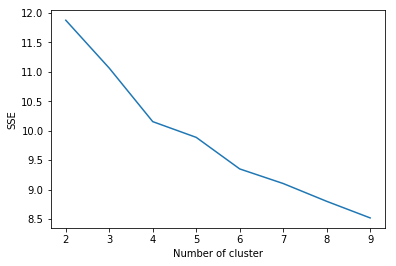

In [367]:
sthlm_grouped_clustering = sthlm_grouped.drop('Metro station', 1)

sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(sthlm_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Let's use one more method for finding best number of clusters, calculating silhouette score. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [258]:
 #   kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=0).fit(sthlm_grouped_clustering)
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=1)
    preds = clusterer.fit_predict(sthlm_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score (sthlm_grouped_clustering, preds, metric='euclidean')
    print(n_clusters, score)

2 0.08542537108122376
3 0.1470027621326062
4 0.1391330115759663
5 0.13812134146641164
6 0.09984707548064758
7 0.09412471141549678
8 0.08068585450620339
9 0.10041914820541688


Both the Elbow method and silhuette score indicate that the optimal number of clusters are 4.

In [387]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=9).fit(sthlm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 2,
       0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0])

Let's see how many stations belong to each cluster:

In [388]:
from collections import Counter, defaultdict
print(Counter(kmeans.labels_))

Counter({0: 64, 1: 22, 2: 13, 3: 1})


To describe stations within each cluster, let's select top 5 most common venues for every station.

Let's find top 5 venue categories for every metro station. There are some metro stations that have less than 5 categories, for those ones we take what's available:

In [389]:
sthlm_grouped

,Metro station,Accessories Store,Advertising Agency,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Castle,Caucasian Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City Hall,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Martial Arts Dojo,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,Newsstand,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Abrahamsberg,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.00000

In [381]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Metro station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
metro_stations_venues_sorted = pd.DataFrame(columns=columns)
metro_stations_venues_sorted['Metro station'] = sthlm_grouped['Metro station']

for ind in np.arange(sthlm_grouped.shape[0]):
    metro_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sthlm_grouped.iloc[ind, :], num_top_venues)
    
metro_stations_venues_sorted

,Metro station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Abrahamsberg,Pizza Place,Steakhouse,Grocery Store,Gym / Fitness Center,Bakery,Indian Restaurant
1,Akalla,Farm,Pizza Place,Middle Eastern Restaurant,Candy Store,Supermarket,Grocery Store
2,Alby,Football Stadium,Shopping Mall,Bus Stop,Pizza Place,Creperie,Event Space
3,Alvik,Hotel,Pizza Place,Modern European Restaurant,Grocery Store,Café,Scandinavian Restaurant
4,Aspudden,Pizza Place,Thai Restaurant,Grocery Store,Convenience Store,Sushi Restaurant,Vietnamese Restaurant
5,Axelsberg,Thai Restaurant,Neighborhood,Grocery Store,Pub,Playground,Flower Shop
6,Bagarmossen,Grocery Store,Pizza Place,Plaza,Scandinavian Restaurant,Sushi Restaurant,Bakery
7,Bandhagen,Bus Station,Pizza Place,Grocery Store,Playground,Café,Stadium
8,Bergshamra,Pizza Place,Bus Stop,Grocery Store,Gym / Fitness Center,Bakery,Restaurant
9,Björkhagen,Pizza Place,Gym / Fitness Center,Nature Preserve,Bakery,Sushi Restaurant,Farmers Market


Let's add cluster labels to the table above and merge it with the table from Wikipedia that contains the coordinates:

In [382]:
# add clustering labels
metro_stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sthlm_merged = df4

# merge XXX toronto_grouped with XXX toronto_data to add latitude/longitude for each metro station
sthlm_merged = sthlm_merged.join(metro_stations_venues_sorted.set_index('Metro station'), on='Station')

sthlm_merged.head()

,Station,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Slussen,18.072327,59.319493,0,Scandinavian Restaurant,Bar,Pub,Cocktail Bar,Bakery,Café
1,Medborgarplatsen,18.073550,59.314342,0,Bar,Café,Clothing Store,Record Shop,Scandinavian Restaurant,Furniture / Home Store
2,Skanstull,18.076229,59.307852,0,Café,Record Shop,Nightclub,Beer Bar,Gym,Thai Restaurant
3,Gullmarsplan,18.080768,59.299114,0,Coffee Shop,Hockey Arena,Greek Restaurant,Fast Food Restaurant,Bowling Alley,Liquor Store
4,Skärmarbrink,18.090440,59.295366,0,Thai Restaurant,Hotel,Concert Hall,Hockey Arena,Eastern European Restaurant,Fast Food Restaurant


In [303]:
sthlm_merged.groupby('Cluster Labels').count()

,Station,Longitude,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Cluster Labels,,,,,,,,
0,53,53,53,53,53,53,53,53
1,27,27,27,27,27,27,27,27
2,20,20,20,20,20,20,20,20


In [304]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sthlm_merged['Latitude'], sthlm_merged['Longitude'], sthlm_merged['Station'], sthlm_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [393]:
cluster_1=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 0, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_1

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Slussen,0,Scandinavian Restaurant,Bar,Pub,Cocktail Bar,Bakery,Café
1,Medborgarplatsen,0,Bar,Café,Clothing Store,Record Shop,Scandinavian Restaurant,Furniture / Home Store
2,Skanstull,0,Café,Record Shop,Nightclub,Beer Bar,Gym,Thai Restaurant
3,Gullmarsplan,0,Coffee Shop,Hockey Arena,Greek Restaurant,Fast Food Restaurant,Bowling Alley,Liquor Store
4,Skärmarbrink,0,Thai Restaurant,Hotel,Concert Hall,Hockey Arena,Eastern European Restaurant,Fast Food Restaurant
11,Globen,0,Nightclub,Gym / Fitness Center,Concert Hall,Coffee Shop,Music Venue,Scenic Lookout
12,Enskede gård,0,Bakery,Stables,Park,Fast Food Restaurant,Ethiopian Restaurant,Event Space
16,Hötorget,0,Gym / Fitness Center,Café,Scandinavian Restaurant,Asian Restaurant,Hotel,Clothing Store
17,Rådmansgatan,0,Italian Restaurant,Café,Scandinavian Restaurant,Hotel,Bakery,Burger Joint
18,Odenplan,0,Bakery,Café,Pizza Place,Italian Restaurant,Scandinavian Restaurant,Burger Joint


In [306]:
cluster_2=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 1, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_2

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Gubbängen,1,Convenience Store,Indian Restaurant,Pharmacy,Fast Food Restaurant,Ethiopian Restaurant
10,Hökarängen,1,Grocery Store,Convenience Store,Coffee Shop,Shopping Plaza,Bakery
26,Brommaplan,1,Sushi Restaurant,Convenience Store,Pub,Liquor Store,Chinese Restaurant
33,Bandhagen,1,Bus Station,Pizza Place,Grocery Store,Playground,Café
34,Högdalen,1,Gym / Fitness Center,Convenience Store,Burger Joint,Bus Stop,Skate Park
36,Hässelby gård,1,Bar,Sushi Restaurant,Grocery Store,Liquor Store,Event Space
41,Kärrtorp,1,Grocery Store,Athletics & Sports,Tennis Court,Indie Theater,Bakery
42,Bagarmossen,1,Grocery Store,Pizza Place,Plaza,Scandinavian Restaurant,Sushi Restaurant
44,Hässelby strand,1,Thai Restaurant,Plaza,Grocery Store,Bus Stop,Farmers Market
46,Hagsätra,1,Shopping Mall,Grocery Store,Food & Drink Shop,Food,Gym / Fitness Center


In [307]:
cluster_3=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 2, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_3

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Blåsut,2,Pizza Place,Hotel,Scandinavian Restaurant,Thai Restaurant,Chinese Restaurant
6,Sandsborg,2,Pizza Place,Scandinavian Restaurant,Pool,Bus Stop,Sushi Restaurant
8,Tallkrogen,2,Pizza Place,Indian Restaurant,Grocery Store,Gym / Fitness Center,Farm
14,Svedmyra,2,Hotel,Thai Restaurant,Bus Station,Supermarket,Pizza Place
25,Abrahamsberg,2,Pizza Place,Steakhouse,Grocery Store,Gym / Fitness Center,Bakery
29,Islandstorget,2,Pizza Place,Soccer Field,Chinese Restaurant,Bus Stop,Bakery
31,Råcksta,2,Pizza Place,Soccer Field,Furniture / Home Store,Supermarket,Flower Shop
39,Hammarbyhöjden,2,Thai Restaurant,Soccer Field,Scandinavian Restaurant,Bakery,Pizza Place
40,Björkhagen,2,Pizza Place,Gym / Fitness Center,Nature Preserve,Bakery,Sushi Restaurant
45,Rågsved,2,Pizza Place,Plaza,Bus Station,Food Court,Food & Drink Shop


In [308]:
cluster_4=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 3, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_4

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [309]:
cluster_5=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 4, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_5

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [310]:
cluster_6=sthlm_merged.loc[sthlm_merged['Cluster Labels'] == 5, sthlm_merged.columns[[0] + list(range(3, sthlm_merged.shape[1]))]]
cluster_6

,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [311]:
c_1=cluster_1.drop(columns=['Cluster Labels','Station'])
c_1.stack().value_counts()

Café                           30
Scandinavian Restaurant        16
Bakery                         13
Pizza Place                    13
Hotel                          10
Italian Restaurant             10
Thai Restaurant                10
Gym / Fitness Center            9
Restaurant                      8
Sushi Restaurant                7
Coffee Shop                     7
Fast Food Restaurant            6
Plaza                           6
Supermarket                     6
Asian Restaurant                6
Clothing Store                  6
Pub                             5
Bus Station                     5
Bar                             5
Grocery Store                   4
Indian Restaurant               4
Burger Joint                    4
Yoga Studio                     3
Playground                      3
Bus Stop                        3
Japanese Restaurant             3
Cocktail Bar                    2
Theater                         2
Electronics Store               2
Concert Hall  

In [312]:
c_2=cluster_2.drop(columns=['Cluster Labels','Station'])
c_2.stack().value_counts()

Grocery Store                  18
Convenience Store              10
Pizza Place                     9
Shopping Mall                   5
Bus Stop                        5
Fast Food Restaurant            5
Yoga Studio                     4
Thai Restaurant                 4
Gym / Fitness Center            4
Sushi Restaurant                4
Bakery                          3
Ethiopian Restaurant            3
Scandinavian Restaurant         3
Bus Station                     3
Food Truck                      2
Liquor Store                    2
Playground                      2
Plaza                           2
Indian Restaurant               2
Café                            2
Pub                             2
Gym                             2
Burger Joint                    2
Tennis Court                    2
Supermarket                     2
Light Rail Station              1
Auto Dealership                 1
Art Gallery                     1
Farm                            1
Indie Theater 

In [315]:
c_3=cluster_3.drop(columns=['Cluster Labels','Station'])
c_3.stack().value_counts()

Pizza Place                  20
Grocery Store                 7
Bus Stop                      7
Bakery                        6
Bus Station                   4
Soccer Field                  4
Thai Restaurant               4
Gym / Fitness Center          4
Scandinavian Restaurant       3
Fast Food Restaurant          2
Café                          2
Hotel                         2
Pool                          2
Sushi Restaurant              2
Chinese Restaurant            2
Supermarket                   2
Food Court                    2
Middle Eastern Restaurant     1
Church                        1
Brewery                       1
Bowling Alley                 1
Furniture / Home Store        1
Creperie                      1
Shopping Mall                 1
Plaza                         1
Indian Restaurant             1
Event Space                   1
Food & Drink Shop             1
Japanese Restaurant           1
Flower Shop                   1
Steakhouse                    1
Ethiopia

In [272]:
c_4=cluster_4.drop(columns=['Cluster Labels','Station'])
c_4.stack().value_counts()

Series([], dtype: int64)

In [316]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
cat_results = requests.get(categories_url).json()

In [317]:
cat_results

{'meta': {'code': 200, 'requestId': '5d2f4f2986bc49002c51042a'},
 'response': {'categories': [{'id': '4d4b7104d754a06370d81259',
    'name': 'Arts & Entertainment',
    'pluralName': 'Arts & Entertainment',
    'shortName': 'Arts & Entertainment',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': [{'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4bf58dd8d48988d1e1931735',
      'name': 'A